# Supervised Learning Capstone Presentation

## Exploring Wage Disparities Across Occupations

In this notebook I will be exploring the Kaggle dataset of the US Bureau of Labor Statistics January 2015 report on income by gender and occupation. The dataset's metadata states that it shows 535 different occupations, and their corresponding weekly median incomes, broken down into men, women, and all, columns. Also included are reported numbers of emplyees for each occupation.

With this data, I would like to see if I can predict the occupational category of a job given input on wage, gender, share of females, gender ratio, wage gap, and if the field is male dominated or has a significant wage gap. 



### A few things to acknowledge before we get started. 

We are going to be using a few different modules for this experiment, including SKLearn heavily. Pandas, Numpy, and Seaborn are here as well. We will be measuring how well we are doing using the different models built in scoring mechanism and also sklearn.metrics accuracy_score, which measures your predicted labels compared to your correct labels. 

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC

%matplotlib inline

In [94]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"


Taking our first look at our data, it looks like the occupation categories are all upper case. There are also a few columns of objects that have numerical values in them. We'll change those over, coercing them to have nan values which we can later drop.

In [95]:
genderwage = pd.read_csv(datafile)
genderwage.head()

Occupation  All_workers All_weekly  M_workers  \
0                  ALL OCCUPATIONS       109080        809      60746   
1                       MANAGEMENT        12480       1351       7332   
2                 Chief executives         1046       2041        763   
3  General and operations managers          823       1260        621   
4                      Legislators            8         Na          5   

  M_weekly  F_workers F_weekly  
0      895      48334      726  
1     1486       5147     1139  
2     2251        283     1836  
3     1347        202     1002  
4       Na          4       Na

In [96]:
genderwage.count()

Occupation     558
All_workers    558
All_weekly     558
M_workers      558
M_weekly       558
F_workers      558
F_weekly       558
dtype: int64

In [97]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [98]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [99]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [100]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

In [101]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

In [102]:
genderwage.insert(1, 'Occupation_Category', 0)

In [103]:
cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    

In [104]:
genderwage.insert(1, 'Occupation_Category_label', 0)

In [105]:
cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

Setting up our cleaned dataframe, we drop all 'Nan' values, and also pluck out the occupation categories, then reset the index. 


In [106]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any').copy()
cleanedgenderwage = cleanedgenderwage.loc[~cleanedgenderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [107]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
SALES                      11
PRODUCTION                 11
CULINARY                    7
HEALTHCARE PROFESSIONAL     7
COMPUTATIONAL               7
EDUCATION                   4
TRANSPORTATION              4
ARTS                        3
SERVICE                     3
SOCIAL SERVICE              3
PROTECTIVE SERVICE          3
SCIENCE                     3
GROUNDSKEEPING              3
ENGINEERING                 2
HEALTHCARE SUPPORT          1
AGRICULTURAL                1
LEGAL                       1
Name: Occupation_Category_label, dtype: int64

If we want to create a model that can work well with new information, we need to have categories that are not so narrow. To solve this problem, we're going to combine a few of them. Healthcare Support will be merged with Healthcare Professional, to become simply Healthcare. Agriculture, Construction, Maintenance, Transportation and Groundskeeping are all things we as a society need to continue, so they will all be rolled in to Infrastructure Support. Education will be rolled into Social Service, because both Education and Social Service jobs are focused on bettering people. Protective Service, Service, Arts, Legal, Engineering, and Science will all be put into Other because of their low count.

In [108]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE PROFESSIONAL', 'Occupation_Category_label'] = 'HEALTHCARE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'CONSTRUCTION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'GROUNDSKEEPING', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'TRANSPORTATION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'EDUCATION', 'Occupation_Category_label'] = 'SOCIAL SERVICE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'PROTECTIVE SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ARTS', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ENGINEERING', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SCIENCE', 'Occupation_Category_label'] = 'OTHER'


In [109]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                    17
MANAGEMENT                16
OTHER                     15
BUSINESS                  12
SALES                     11
PRODUCTION                11
HEALTHCARE                 8
INFRASTRUCTURE SUPPORT     8
CULINARY                   7
SOCIAL SERVICE             7
COMPUTATIONAL              7
Name: Occupation_Category_label, dtype: int64

## Preliminary Data Exploration

Here we will take a look at the distributions of male to female workers, male to female wages, and finally see a scatter plot of male to female wages.

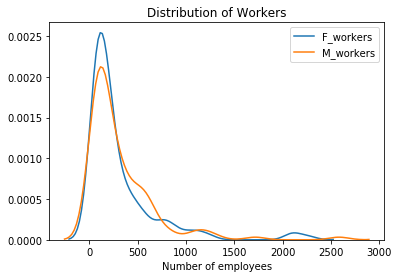

In [110]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.xlabel('Number of employees')
plt.title('Distribution of Workers')
plt.show()

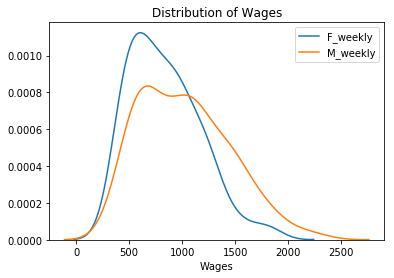

In [111]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.title('Distribution of Wages')
plt.xlabel('Wages')
plt.show()

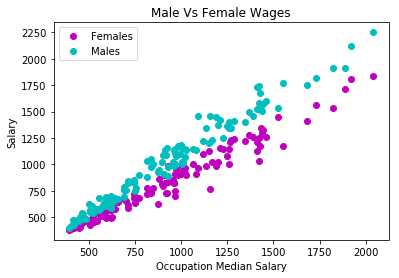

In [112]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.title('Male Vs Female Wages')
plt.ylabel('Salary')
plt.show()

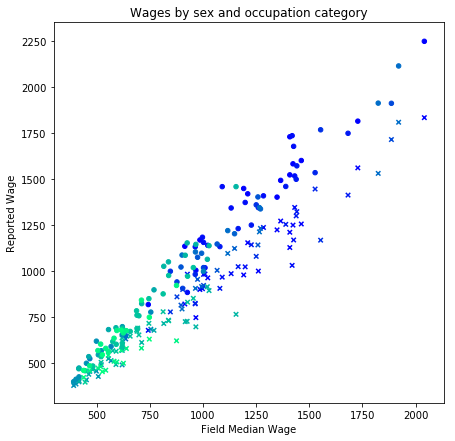

In [113]:
# plot wage by gender and color by occupation category
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title("Wages by sex and occupation category")
ax.set_xlabel("Field Median Wage")
ax.set_ylabel("Reported Wage")
x = cleanedgenderwage['All_weekly']
y = cleanedgenderwage['F_weekly']
y2 = cleanedgenderwage['M_weekly']
colors = [str(item) for item in cleanedgenderwage['Occupation_Category_label']]

ax.scatter(x, y, s=20,
           c=cleanedgenderwage['Occupation_Category'],
           label=cleanedgenderwage['Occupation_Category_label'],
           marker = 'x',
           cmap=plt.cm.winter)
ax.scatter(x, y2 ,s=20,
           c=cleanedgenderwage['Occupation_Category'],
           label=cleanedgenderwage['Occupation_Category_label'],
           marker = 'o',
           cmap=plt.cm.winter)
#ax.legend()
#plt.colorbar()
plt.show()


# Now lets create some features

talk about wage gap ratio feature and why you made it

Again, talk about why you made the gender ratio

Then I made two complimentary columns of the mens and womens share of workers by dividing each by all workers. The colinearity of these features is noted. talk more here

In [114]:
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']


## Next I marked which occupations are male dominated

Any ratio under .45 is considered male dominated as that shows a distinct majority over women.

## I also made a column marking occupations with significant wage gaps

For our purposes, a significant wage gap is a difference of 15% or more over women.

In [115]:
cleanedgenderwage['Male_Dominated'] = np.where(cleanedgenderwage['F_share'] > .45, 0, 1)
cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

## Lets plot some of these new features

We'll look at a distribution plot of the wage gap, bar plots of weekly income by occupation, wage gap by occupation, gender ratio by occupation, wage ratio by occupation, and a scatter plot of mens weekly income and womens weekly income as a function of the reported occupation median income, color coded to each occupation.

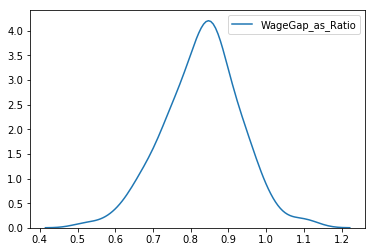

In [116]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])
plt.show()

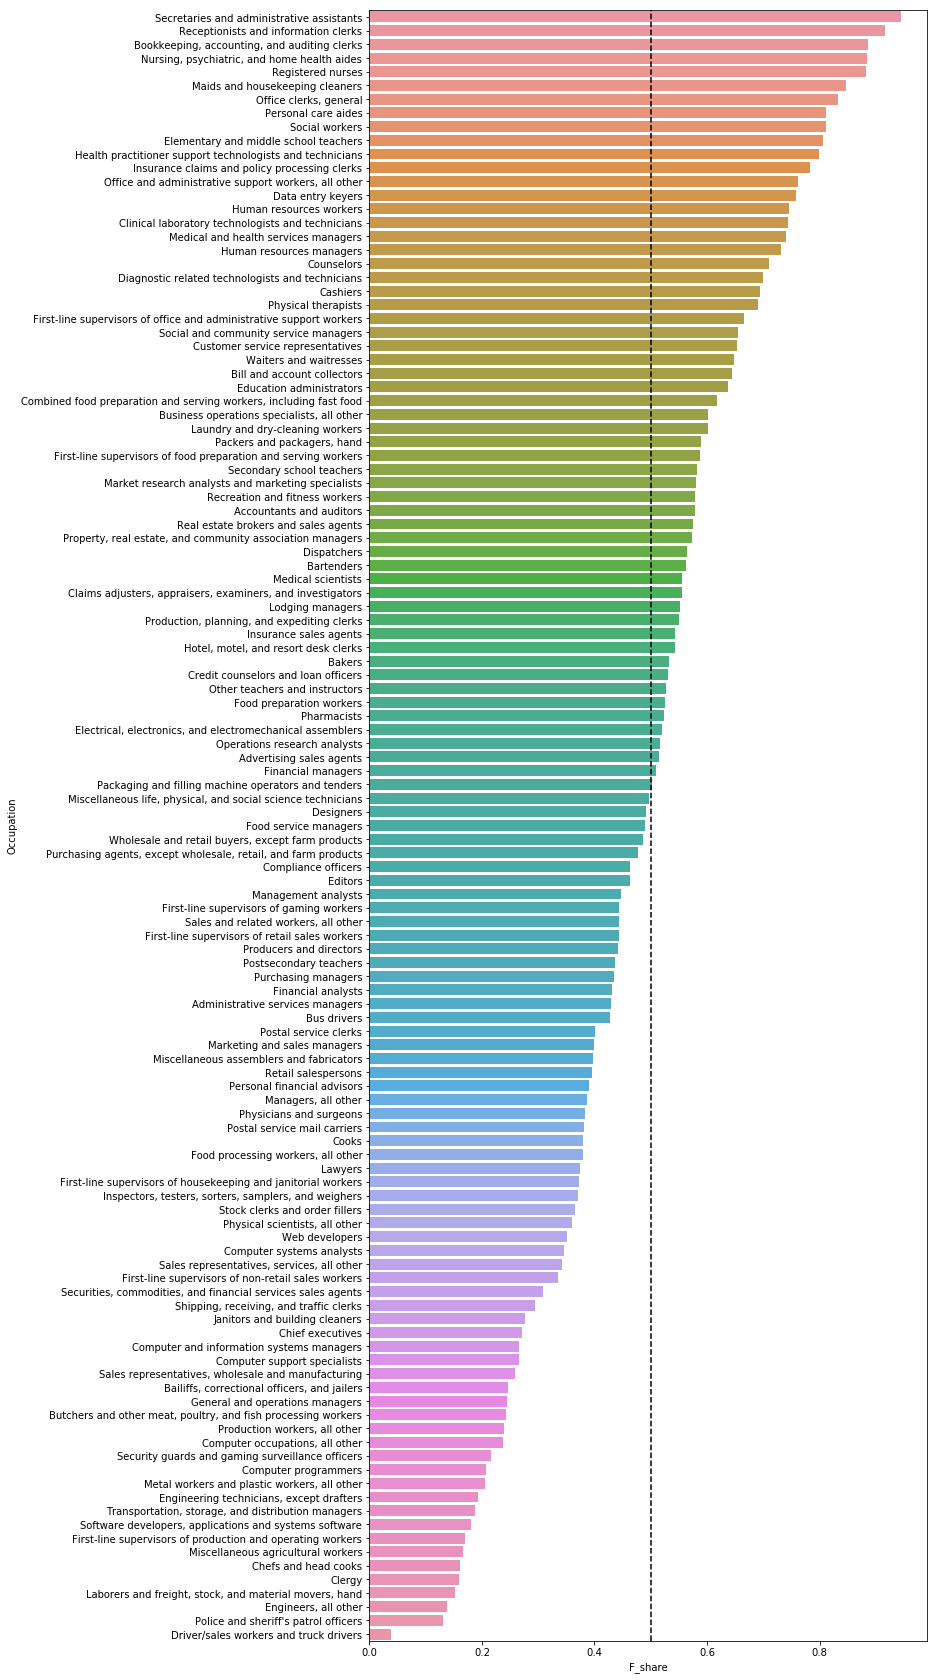

In [118]:

# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='F_share',
            y='Occupation',
            data=cleanedgenderwage.sort_values('F_share', ascending=False))
plt.axvline(x=.5, color='black', linestyle='--') # equality at 50%
plt.show()

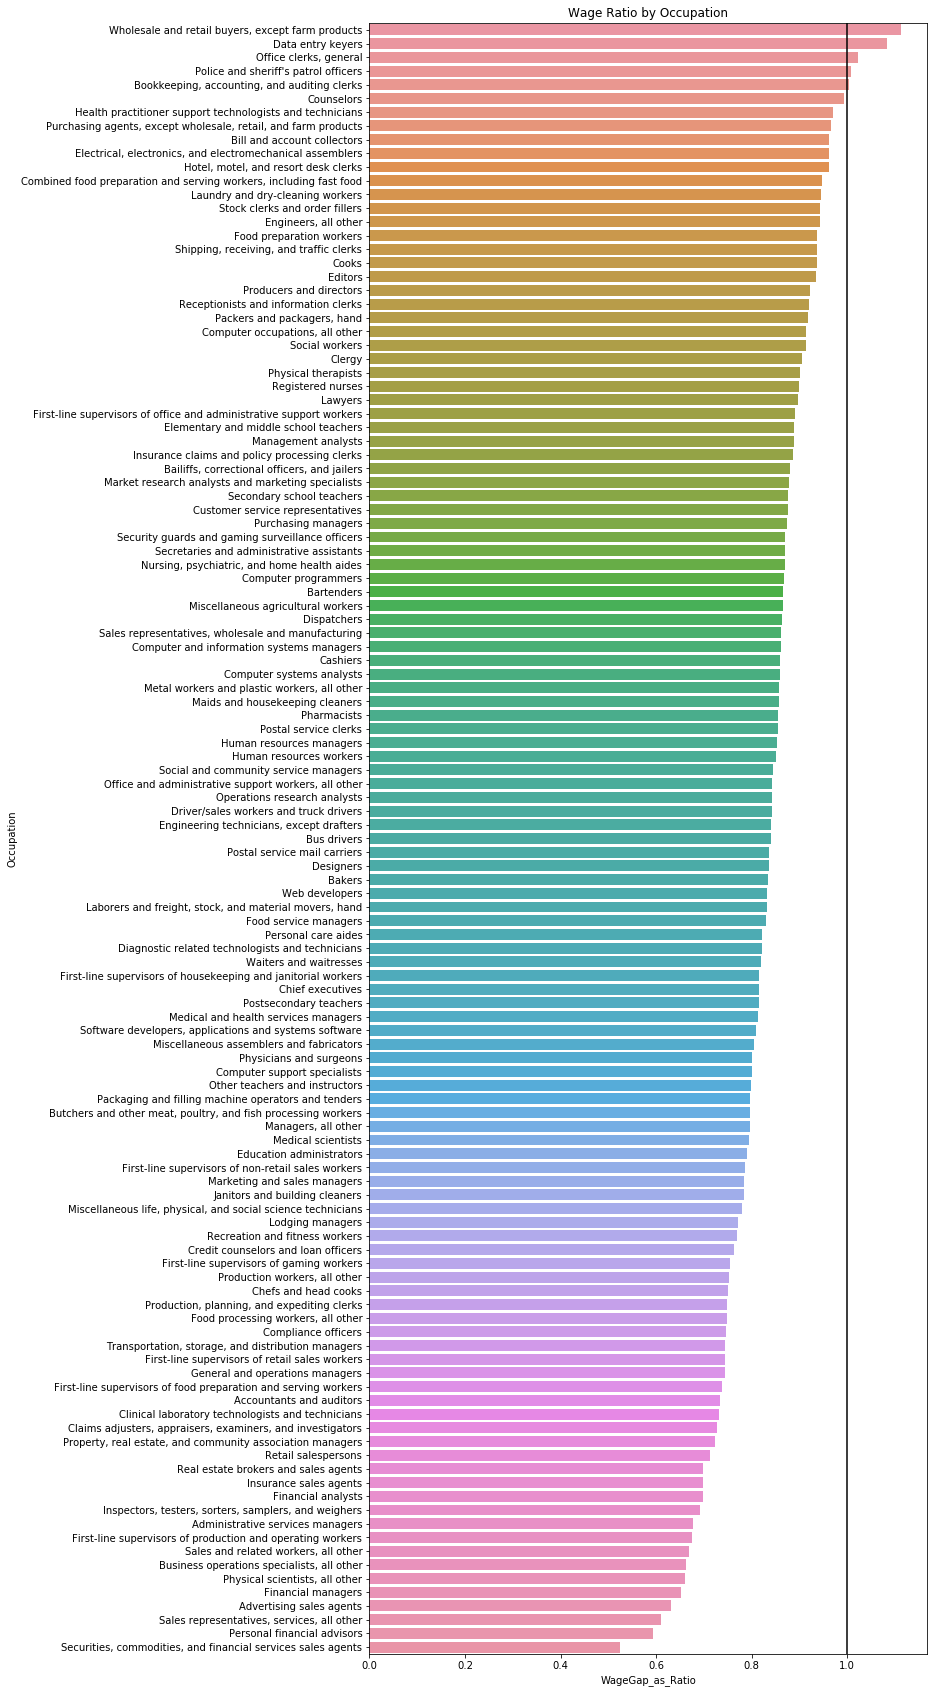

In [119]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio', ascending=False))
plt.axvline(x=1, color='black', linestyle='solid')
plt.title('Wage Ratio by Occupation')
plt.show()

# Lets look at a bigger scatter plot of m/f incomes, and color it according to occupation

# Time for some MODELS

The questions I will be looking to answer today is:
     - Can we predict the occupational category given wage, gender, share of females for that field, if that field is male dominated or not, and if that field has a significant wage gap? 



I want to try several different classifiers so I'll make a quick function that will allow me to choose the model to test, the data, and then will return me an accuracy score. 

In [121]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3, ratio='auto', kind='regular')

## Next steps are to scale our data, split it up and resample our training data, then test our models.

In [124]:
# scale columns here
scaler = StandardScaler()
columns = ['M_weekly',
           'F_weekly',
           'Male_Dominated',
           'Significant_wage_gap',
           'WageGap_as_Ratio',
           'F_share']

# split up data first, then resample only the training data, maybe try smote again
X = cleanedgenderwage[columns]

X_std = StandardScaler().fit_transform(X)
y = cleanedgenderwage['Occupation_Category_label']

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.4)

# try smote again
X_smote, y_smote = smote.fit_sample(X_train, y_train)

# make models that are not empty

# use GridSearchCV to find the best params and estimator

# make iterator to go over estimators and params

In [157]:
logr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [176]:
from sklearn.model_selection import GridSearchCV

#class Testing:
#    pass
#model1 = Testing()
#model1

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    print(grid_score)

In [ ]:
log_param = {'tol': (.01, .5, 1, 5),
             'C': (.01, .5, 1, 5),
             'solver': ('newton-cg', 'lbfgs', 'sag')}
forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
dtree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}
svc_param = {'C': (.1, .5, 1, 5),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'degree': (2, 3, 4, 5),
             'gamma': (1, 2, 3)}



In [221]:
# got my estimators
gradient = ensemble.GradientBoostingClassifier()
extree = ensemble.ExtraTreesClassifier()
dtree = tree.DecisionTreeClassifier()
svc = SVC()
forest = ensemble.RandomForestClassifier()
logr = linear_model.LogisticRegression()

In [231]:
# Iterate over the kinds of models using grid_check and then return the one that is the best
# somehow
estimators = [logr,
              gradient,
              extree,
              dtree,
              svc,
              forest]
params = [log_param,
          gradient_param,
          forest_type_param,
          dtree_param,
          svc_param,
          forest_type_param]
# use cross_val_score in the scoring of the estimators somehow

# you can do this. somehow. anyway you want

for estimator, param in list(zip(estimators, params)):
    results = []
    results.append(estimator)
    results.append(check_grid(estimator, param, X_std, y))
    print(results)



0.46218487394957986
[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), None]
0.773109243697479
[GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), None]
0.8571428571428571
[ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impu

In [235]:
Extra_tree = ensemble.ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False)

print(cross_val_score(Extra_tree, X_std, y, cv=4))
print(np.mean(cross_val_score(Extra_tree, X_std, y, cv=4)))

[0.34375    0.25806452 0.35483871 0.28      ]
0.2732157258064516


In [241]:
# look at confusion matrix here

# confusion_matrix(y_true, y_pred)
y_pred = extree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [3, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0],
       [4, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0],
       [1, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])

In [243]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, y_pred, average='macro')


/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.2929752066115702, 0.2523809523809524, 0.24428548278815662, None)

In [239]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

AttributeError: 'function' object has no attribute 'sum'

In [133]:
# look at area under the curve here
# y = np.array([1, 1, 2, 2])
#>>> pred = np.array([0.1, 0.4, 0.35, 0.8])
#>>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
#>>> metrics.auc(fpr, tpr)


# errors in classifying?

model validation looks at how well the model performed, where it messed up and it does that by looking at a confusion matrix and the area under the curve score, and examining where the classifier went wrong. 

# Put conclusion here

I'm not upset by those scores. I don't think. 69% accuracy is pretty good when chance is 8%, right?

# Next steps go here